## Image Captioning: Vision Transformer with PyTorch
#### Dataset: [Flickr 8k](https://www.kaggle.com/datasets/adityajn105/flickr8k)
- 1. Preparing Data
    - [1.1 Image Normalization](#1.1-Image-Normalization)
    - [1.2 Vocabulary & Data Loader](#1.2-Vocabulary-&-Data-Loader)
- 2. Transformer
    - [2.1 Encoder CNN](#2.1-Encoder-CNN)
    - [2.2 Attention](#2.2-Attention)
    - [2.3 Decoder LSTM](#2.3-Decoder-LSTM)
- 3. [Training and Evaluation](#Training-and-Evaluation)
- 4. [Visualizing the Attentions](#Visualizing-the-Attentions)

Inspired on this [notebook](https://www.kaggle.com/code/mdteach/image-captioning-with-attention-pytorch).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torchvision.models as models
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset,random_split
from collections import Counter
from PIL import Image
import time

# NLP
import nltk
from wordcloud import WordCloud

In [2]:
root_dir = '/kaggle/input/flickr8k'

data = pd.read_csv(root_dir + "/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


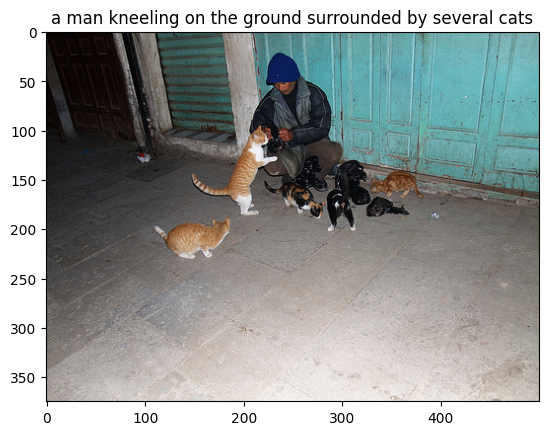

In [3]:
search = 'cats'

image_name = data[data['caption'].str.contains(search, case=False)]['image'].iloc[1]
caption = data[data['image'] == image_name]['caption'].iloc[0]

img = Image.open(root_dir + '/Images/' + image_name)
plt.imshow(img)
plt.title(caption)
plt.show()

### 1. Preparing Data
#### 1.1 Image Normalization

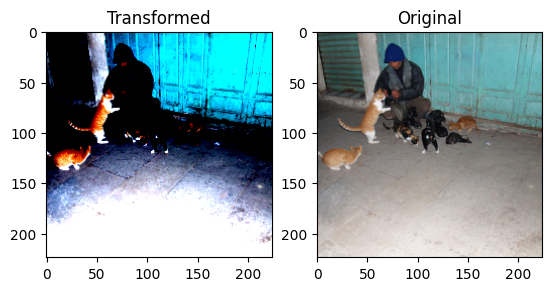

In [4]:
transform = T.Compose([
    T.Resize(226),
    T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

def inverse_transform(img):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img *= std
    img += mean

# Plot transformed vs. original
img = Image.open(root_dir + '/Images/' + image_name)
img = transform(img).numpy().transpose((1, 2, 0))

fig, axs = plt.subplots(1, 2)

axs[0].imshow(img)
axs[0].set_title('Transformed')

inverse_transform(img)
axs[1].imshow(img)
axs[1].set_title('Original')

plt.show()

#### 1.2 Vocabulary & Data Loader

In [5]:
class Vocabulary:
    def __init__(self):
        self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"} # index to string (decoder)
        self.stoi = {v: k for k, v in self.itos.items()} # string to index (encoder)
        self.word_freq = Counter()
        
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.lower() for token in nltk.word_tokenize(text)]
    
    def build_vocab(self, sentences):
        idx = len(self.itos)
        
        for sentence in sentences:
            for word in self.tokenize(sentence):
                self.word_freq[word] += 1
                
                if self.word_freq[word] == 4: # ignore words with less than 4 occurences
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokens = self.tokenize(text)
        tokens = [self.stoi.get(token, self.stoi["<UNK>"]) for token in tokens]
        return tokens

In [6]:
class FlickrDataset(Dataset):
    def __init__(self, transform):
        self.data = pd.read_csv(root_dir + '/captions.txt')
        self.transform = transform
        self.images = self.data["image"]
        self.captions = self.data["caption"]
        self.vocab = Vocabulary()
        self.vocab.build_vocab(self.captions.tolist())
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Normalize image
        img_name = self.images[idx]
        img = Image.open(root_dir + '/Images/' + img_name)
        img = self.transform(img)
        
        # Tokenize caption
        caption = self.captions[idx]
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)

In [7]:
class CapsCollate:
    def __init__(self, pad_idx, batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs, targets

In [8]:
batch_size = 256
num_workers = 4

dataset = FlickrDataset(transform)

train_size = int(len(dataset)*0.95)
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=dataset.vocab.stoi["<PAD>"], batch_first=True)
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    collate_fn=CapsCollate(pad_idx=dataset.vocab.stoi["<PAD>"], batch_first=True)
)

vocab_size = len(dataset.vocab)
vocab_size

3445

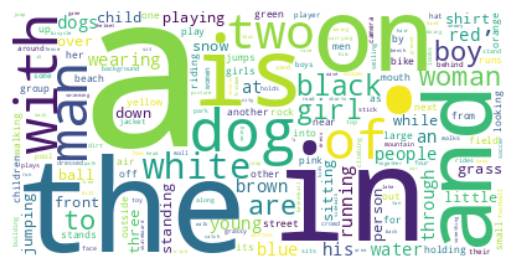

In [9]:
wordcloud = WordCloud(background_color ='white').generate_from_frequencies(dataset.vocab.word_freq)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 2. Transformer

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### 2.1 Encoder CNN
- Input:
    - RGB 224x224 images: (3, 224, 224)
- Output:
    - ResNet50 2048-Featured 7x7 images: (49, 2048)

In [11]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

    def forward(self, images):                                            # (None, 3, 224, 224)
        features = self.resnet(images)                                    # (None, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1)                           # (None, 7, 7, 2048)
        features = features.view(features.size(0), -1, features.size(-1)) # (None, 49, 2048)
        return features

#### 2.2 Attention

In [12]:
# Bahdanau Attention
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attn_dim):
        super(Attention, self).__init__()
        self.attn_dim = attn_dim
        self.W = nn.Linear(decoder_dim, attn_dim)
        self.U = nn.Linear(encoder_dim, attn_dim)
        self.A = nn.Linear(attn_dim, 1)
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     # (None, num_layers, attn_dim)
        w_ah = self.W(hidden_state) # (None, attn_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) # (None, num_layers, attn_dim)
        
        attn_scores = self.A(combined_states)    # (None, num_layers, 1)
        attn_scores = attn_scores.squeeze(2)     # (None, num_layers)
        
        alpha = F.softmax(attn_scores,dim=1)     # (None, num_layers)
        
        attn_weights = features * alpha.unsqueeze(2)  # (None, num_layers, features_dim)
        attn_weights = attn_weights.sum(dim=1)        # (None, num_layers)
        
        return alpha, attn_weights

#### 2.3 Decoder LSTM

In [13]:
class DecoderLSTM(nn.Module):
    def __init__(self, embed_size, vocab_size, attn_dim, encoder_dim, decoder_dim, drop_prob):
        super().__init__()
        self.vocab_size = vocab_size
        self.attn_dim = attn_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attn_dim)
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
    def forward(self, features, captions):
        embeds = self.embedding(captions)
        
        h, c = self.init_hidden_state(features) # (batch_size, decoder_dim)
        
        seq_length = len(captions[0]) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)
        
        for seq in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, seq], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:, seq] = output
            alphas[:, seq] = alpha
        
        return preds, alphas
    
    def generate_caption(self, features, max_len=20, vocab=None):        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(device)
        embeds = self.embedding(word)

        tokenized_caps = []
        
        for i in range(max_len):
            alpha, context = self.attention(features, h)
            
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            predicted_word_idx = output.argmax(dim=1)
            tokenized_caps.append(predicted_word_idx.item())
            
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        caps = [vocab.itos[i] for i in tokenized_caps]
        return caps, alphas
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

#### 2.4 Final model

In [14]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attn_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderLSTM(
            embed_size=embed_size,
            vocab_size=vocab_size,
            attn_dim=attn_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim,
            drop_prob=drop_prob
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [15]:
def load_model(model):
    model_state = torch.load('attention_model_state.pth')
    model.load_state_dict(model_state['state_dict'])
    return model

def save_model(model, num_epochs):
    model_state = {
        'num_epochs': num_epochs,
        'embed_size': embed_size,
        'vocab_size': vocab_size,
        'attn_dim': attn_dim,
        'encoder_dim': encoder_dim,
        'decoder_dim': decoder_dim,
        'state_dict': model.state_dict()
    }
    torch.save(model_state, 'attention_model_state.pth')

In [16]:
# Hyperparameters
embed_size = 300
attn_dim = 256
encoder_dim = 2048
decoder_dim = 512
learning_rate = 1e-3

model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attn_dim=attn_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

# model = load_model(model)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 167MB/s] 


EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

## Training and Evaluation

In [17]:
epochs = 5
print_freq = 20

for epoch in range(epochs):
    start_epoch = time.time()
    # Training
    model.train()
    start_step = time.time()
    for i, (image, captions) in enumerate(train_loader):
        image, captions = image.to(device), captions.to(device)

        optimizer.zero_grad()

        outputs, attentions = model(image, captions)

        targets = captions[:, 1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))

        loss.backward()
        optimizer.step()

        if (i + 1) % print_freq == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Step {i + 1}/{len(train_loader)}, Train loss: {loss.item():.4f}, Time: {time.time() - start_step:.2f}s')
            start_step = time.time()
            
    # Validation
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for i, (image, captions) in enumerate(val_loader):
            image, captions = image.to(device), captions.to(device)
            outputs, attentions = model(image, captions)
            targets = captions[:, 1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            validation_loss += loss.item()

    validation_loss /= len(val_loader)

    end_epoch = time.time()
    print(f'Epoch {epoch + 1} completed in {(end_epoch - start_epoch) / 60:.2f}m')
    print(f'Validation loss: {validation_loss:.4f}')
    
    # save_model(model, epoch)

Epoch 1/4, Step 20/143, Train loss: 4.9062, Time: 30.88s
Epoch 1/4, Step 40/143, Train loss: 4.5031, Time: 22.34s
Epoch 1/4, Step 60/143, Train loss: 4.2177, Time: 19.81s
Epoch 1/4, Step 80/143, Train loss: 3.8858, Time: 18.94s
Epoch 1/4, Step 100/143, Train loss: 3.8101, Time: 19.01s
Epoch 1/4, Step 120/143, Train loss: 3.6591, Time: 18.56s
Epoch 1/4, Step 140/143, Train loss: 3.7073, Time: 18.52s
Epoch 1 completed in 2.77m
Validation loss: 3.5446
Epoch 2/4, Step 20/143, Train loss: 3.5355, Time: 22.73s
Epoch 2/4, Step 40/143, Train loss: 3.4486, Time: 18.44s
Epoch 2/4, Step 60/143, Train loss: 3.3515, Time: 18.77s
Epoch 2/4, Step 80/143, Train loss: 3.3335, Time: 19.15s
Epoch 2/4, Step 100/143, Train loss: 3.1548, Time: 18.75s
Epoch 2/4, Step 120/143, Train loss: 3.2850, Time: 17.88s
Epoch 2/4, Step 140/143, Train loss: 3.1200, Time: 17.91s
Epoch 2 completed in 2.53m
Validation loss: 3.1207
Epoch 3/4, Step 20/143, Train loss: 3.1009, Time: 20.36s
Epoch 3/4, Step 40/143, Train loss: 3

## Visualizing the Attentions

In [24]:
def unnormalize(img):
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406

def get_caps_from(features_tensors):
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
        caption = ' '.join(caps)
        
        # Show image
        img = features_tensors[0]
        unnormalize(img)
        img = img.numpy().transpose((1, 2, 0))
        
        plt.imshow(img)
        plt.title(caption)
        plt.show()
    
    return caps, alphas

def plot_attention(img, result, attention_plot):
    unnormalize(img)
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, alpha=0.7, extent=img.get_extent())
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

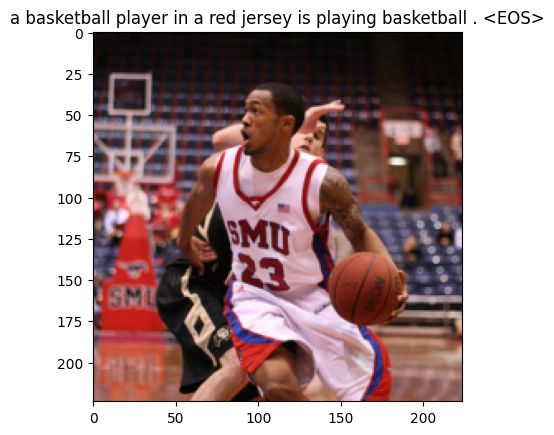

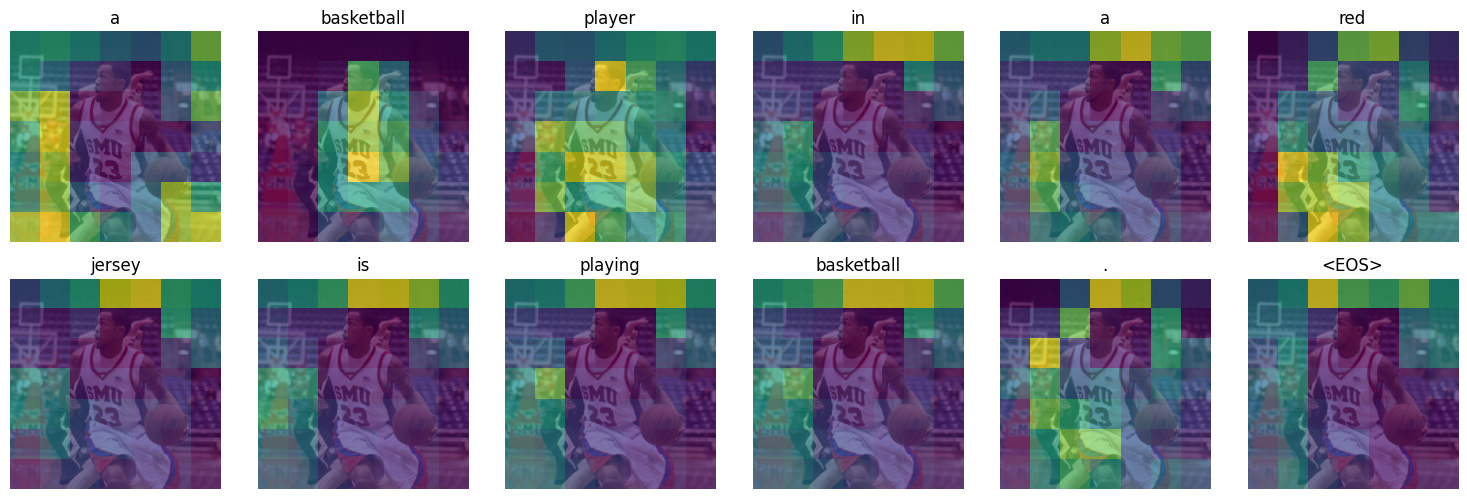

In [25]:
# Show any
dataiter = iter(train_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps, alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)